In [7]:
import pycaret
import pandas as pd

In [9]:
# อ่านไฟล์ CSV
data = pd.read_csv('export_data/filtered_data_3_best.csv')

In [10]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [11]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")

row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [12]:
# เพิ่มคอลัมน์วันที่ต่างๆ
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week

In [13]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [17]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [14]:
data.columns

Index(['humidity', 'pm_10', 'pm_2_5', 'pm_2_5_sp', 'temperature', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'season'],
      dtype='object')

In [15]:
data.tail()

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,year,month,day,day_of_week,week_of_year,season
timestamp,,,,,,,,,,,
2025-02-07 07:00:00,70.933952,34.743259,29.321219,26.166471,28.271927,2025,2,7,4,6,0
2025-02-08 07:00:00,69.348548,30.654249,26.000000,22.380675,28.385596,2025,2,8,5,6,0
2025-02-09 07:00:00,69.916384,28.971065,24.616898,20.976852,28.373742,2025,2,9,6,6,0
2025-02-10 07:00:00,71.226336,30.652667,25.856981,22.374574,28.251201,2025,2,10,0,7,0
2025-02-11 07:00:00,68.159624,32.532955,27.522727,24.120455,28.693799,2025,2,11,1,7,0


In [18]:
data = data[['temperature','year','month', 'day', 'day_of_week', 'week_of_year', 'season', 'is_weekend']]

In [ ]:
# data = data['temperature']

<Axes: xlabel='timestamp'>

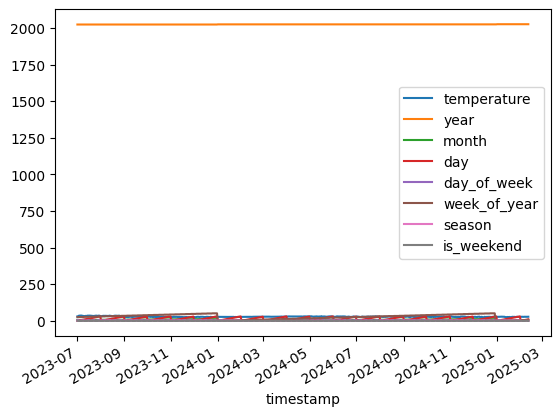

In [19]:
data.plot()

In [20]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

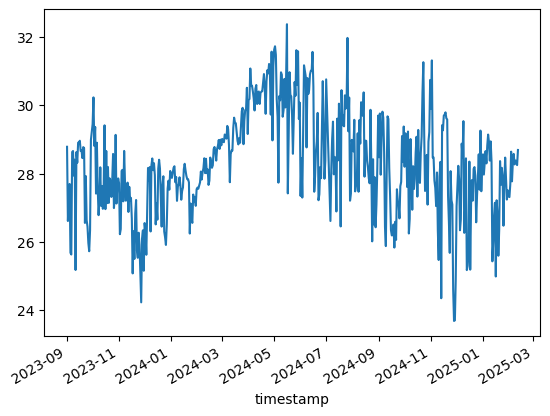

In [21]:
data_filtered.temperature.plot()

In [302]:
data_filtered.head()

,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend
timestamp,,,,,,,,
2023-09-01 07:00:00,28.787466,2023,9,1,4,35,2,0
2023-09-02 07:00:00,26.614617,2023,9,2,5,35,2,1
2023-09-03 07:00:00,27.347189,2023,9,3,6,35,2,1
2023-09-04 07:00:00,27.699339,2023,9,4,0,36,2,0
2023-09-05 07:00:00,25.685899,2023,9,5,1,36,2,0


In [303]:
# data_filtered.columns

In [304]:
from pycaret.time_series import *
# ตั้งค่าของ PyCaret
s = setup(data=data_filtered, target='temperature', fh=24, session_id=123)

,Description,Value
0,session_id,123
1,Target,temperature
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(530, 8)"
5,Transformed data shape,"(530, 8)"
6,Transformed train set shape,"(506, 8)"
7,Transformed test set shape,"(24, 8)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [305]:
# compare baseline models
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.9008,0.9267,1.2438,1.5955,0.0468,0.0456,-0.3304,0.2867
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.9241,0.9382,1.2725,1.6069,0.0480,0.0467,-0.2331,0.2733
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.9640,0.9780,1.3283,1.6783,0.0500,0.0486,-0.4104,0.2800
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.9821,0.9304,1.3540,1.5954,0.0508,0.0496,-0.2346,0.3633
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9956,0.9998,1.3719,1.7149,0.0520,0.0501,-0.4265,0.4333
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.9978,0.9897,1.3756,1.6993,0.0521,0.0503,-0.4218,0.4867
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.0104,0.9854,1.3929,1.6884,0.0525,0.0510,-0.3638,0.2700
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.0132,1.0297,1.3969,1.7681,0.0530,0.0511,-0.5479,0.5333
croston,Croston,1.0146,0.9741,1.3983,1.6701,0.0522,0.0512,-0.3394,0.0267
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.0872,1.1329,1.5014,1.9498,0.0571,0.0545,-1.0407,0.3633


In [252]:
best_1 = create_model('et_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9299,1.0181,1.2138,1.6415,0.0433,0.0429,-0.1822
1,2024-11-13,1.2712,1.2807,1.7245,2.1398,0.0652,0.0630,-0.4088
2,2024-12-13,0.4822,0.5271,0.6769,0.9277,0.0249,0.0247,0.3086
Mean,NaT,0.8944,0.9419,1.2050,1.5697,0.0445,0.0435,-0.0941
SD,NaT,0.3231,0.3123,0.4277,0.4974,0.0165,0.0157,0.2994


In [253]:
best_2 = create_model('ada_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9450,0.9784,1.2334,1.5775,0.0432,0.0437,-0.0918
1,2024-11-13,1.1838,1.1821,1.6059,1.9751,0.0604,0.0588,-0.2002
2,2024-12-13,0.6184,0.5937,0.8682,1.0451,0.0316,0.0316,0.1226
Mean,NaT,0.9157,0.9181,1.2358,1.5326,0.0451,0.0447,-0.0565
SD,NaT,0.2317,0.2440,0.3012,0.3810,0.0118,0.0112,0.1342


In [254]:
best_3 = create_model('croston')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9108,0.9789,1.1889,1.5784,0.0417,0.0421,-0.0931
1,2024-11-13,1.1069,1.0877,1.5015,1.8173,0.0562,0.0551,-0.0161
2,2024-12-13,0.7924,0.7149,1.1124,1.2583,0.0401,0.0405,-0.2718
Mean,NaT,0.9367,0.9272,1.2676,1.5513,0.0460,0.0459,-0.1270
SD,NaT,0.1297,0.1565,0.1683,0.2290,0.0073,0.0066,0.1071


In [255]:
tune_1 = tune_model(best_1)
tune_2 = tune_model(best_2)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9467,1.0292,1.2357,1.6595,0.0441,0.0436,-0.2082
1,2024-11-13,1.2305,1.2611,1.6692,2.1071,0.0635,0.0610,-0.3660
2,2024-12-13,0.5005,0.5700,0.7026,1.0033,0.0262,0.0256,0.1914
Mean,NaT,0.8926,0.9534,1.2025,1.5900,0.0446,0.0434,-0.1276
SD,NaT,0.3004,0.2872,0.3953,0.4533,0.0153,0.0144,0.2346


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9314,0.9791,1.2157,1.5787,0.0424,0.0430,-0.0935
1,2024-11-13,1.1466,1.1193,1.5555,1.8702,0.0577,0.0571,-0.0761
2,2024-12-13,1.0362,0.9002,1.4546,1.5845,0.0518,0.0532,-1.0166
Mean,NaT,1.0381,0.9995,1.4086,1.6778,0.0506,0.0511,-0.3954
SD,NaT,0.0879,0.0906,0.1425,0.1361,0.0063,0.0059,0.4393


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


In [264]:
# blend = blend_models([best_1, best_2])
blend = blend_models([tune_1, tune_2])

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.8896,0.9795,1.1611,1.5793,0.0411,0.0411,-0.0942
1,2024-11-13,1.1952,1.2123,1.6214,2.0256,0.0614,0.0594,-0.2624
2,2024-12-13,0.5457,0.5605,0.7660,0.9865,0.0282,0.0279,0.2182
Mean,NaT,0.8768,0.9174,1.1828,1.5305,0.0436,0.0428,-0.0461
SD,NaT,0.2653,0.2697,0.3495,0.4256,0.0137,0.0129,0.1991


In [257]:
tune = tune_model(blend)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.8986,0.9786,1.1728,1.5779,0.0415,0.0415,-0.0924
1,2024-11-13,1.2156,1.2237,1.6490,2.0445,0.0623,0.0604,-0.2861
2,2024-12-13,0.5345,0.5458,0.7503,0.9608,0.0275,0.0273,0.2585
Mean,NaT,0.8829,0.9160,1.1907,1.5278,0.0437,0.0431,-0.0400
SD,NaT,0.2783,0.2802,0.3671,0.4439,0.0143,0.0135,0.2254


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.8s finished


In [299]:
plot_model(best, plot = 'forecast')

In [259]:
x = predict_model(blend, fh = 30)
x

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,0.6105,0.5872,0.8744,1.0535,0.0322,0.0319,-0.2935


,y_pred
2025-01-13,27.6891
2025-01-14,27.8172
2025-01-15,28.3015
2025-01-16,27.6127
2025-01-17,27.9949
2025-01-18,27.7426
2025-01-19,27.2326
2025-01-20,27.5933
2025-01-21,27.6797
2025-01-22,28.2577


In [260]:
final_best = finalize_model(tune)

In [261]:
x = predict_model(final_best, fh=60)
x

,y_pred
2025-02-12,27.9681
2025-02-13,27.5231
2025-02-14,27.8827
2025-02-15,27.7209
2025-02-16,27.3589
2025-02-17,27.5582
2025-02-18,27.3915
2025-02-19,27.6451
2025-02-20,28.0649
2025-02-21,28.2207


In [262]:
data.head()

timestamp
2023-07-01 07:00:00    31.131941
2023-07-02 07:00:00    32.240924
2023-07-03 07:00:00    35.841610
2023-07-04 07:00:00    36.269393
2023-07-05 07:00:00    36.176134
Freq: D, Name: temperature, dtype: float64

In [263]:
# save pipeline
save_model(best, 'temp_eng2')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 NaiveForecaster(strategy='mean'))]))]),
 'temp_eng2.pkl')